# SKKU SWE3050-41 HW4, Q5
In this task, we will apply Iris dataset from `scikit-learn`.

A. Perform k-Means clustering with k=2, 3, 6.
* Select the best k. Explain the reason.

========================================================================================================
The iris dataset has three known species, and when we compare cluster labels with the true class labels (e.g., using ARI), we choose `k = 3`, which  gives the best agreement and a good silhouette score, while `k = 2` merges two species into one cluster and `k = 6` over-segments the data.

`k = 2`: good silhouette; ignores the fact that there are three species.

`k = 6`: smaller inertia (can lead to overfitting), lower silhouette and worst API.

========================================================================================================

* Visualize the performance with different k curves.

In [22]:
from sklearn.datasets import load_iris
import numpy as np

# load the dataset
data = load_iris()
X = data.data # features: sepal length/width, petal length/width
y = data.target # true labels: 3 species
feature_names = data.feature_names
target_names = data.target_names


In [23]:
# perform k means with k = 2,3,6

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt

k_values = [2, 3, 6]
inertias = []
silhouettes = []
aris = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X)

    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, labels))
    aris.append(adjusted_rand_score(y, labels))

    print(f"k = {k}")
    print(f"  Inertia:          {kmeans.inertia_:.2f}")
    print(f"  Silhouette score: {silhouette_score(X, labels):.3f}")
    print(f"  ARI vs labels:    {adjusted_rand_score(y, labels):.3f}")
    print()


k = 2
  Inertia:          152.35
  Silhouette score: 0.681
  ARI vs labels:    0.540

k = 3
  Inertia:          78.85
  Silhouette score: 0.553
  ARI vs labels:    0.730

k = 6
  Inertia:          39.04
  Silhouette score: 0.365
  ARI vs labels:    0.448



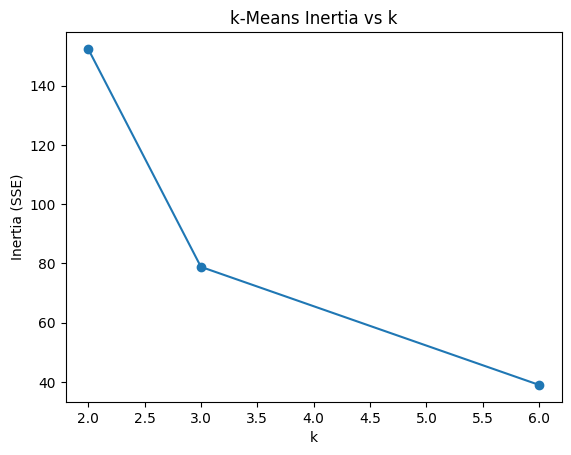

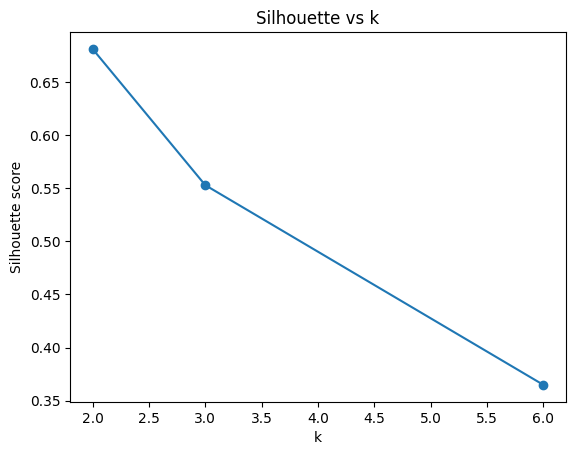

In [24]:
# visualise performance with different k curves

plt.figure()
plt.plot(k_values, inertias, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.title("k-Means Inertia vs k")
plt.show()

plt.figure()
plt.plot(k_values, silhouettes, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette vs k")
plt.show()


B. Apply DBSCAN to the same dataset and compare the number of clusters detected.  

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# tweak eps and min_samples a bit
dbscan = DBSCAN(eps=0.6, min_samples=5)
db_labels = dbscan.fit_predict(X_scaled)

# count clusters (excluding noise label -1)
unique_labels = set(db_labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = list(db_labels).count(-1)

print(f"DBSCAN found {n_clusters} clusters and {n_noise} noise points.")
print("Cluster labels:", unique_labels)

DBSCAN found 2 clusters and 26 noise points.
Cluster labels: {np.int64(0), np.int64(1), np.int64(-1)}


C. Train a support vector classifier using an RBF kernel

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

svc = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"SVC (RBF) accuracy: {acc:.3f}")
print(classification_report(y_test, y_pred, target_names=target_names))

SVC (RBF) accuracy: 0.956
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.93      0.93      0.93        15
   virginica       0.93      0.93      0.93        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



D. Use SHAP or LIME to interpret predictions for three sample points and summarize what the explanation shows.

In [27]:
!pip install shap

  0%|          | 0/3 [00:00<?, ?it/s]


Explanation for sample test index 0 (true label = virginica):


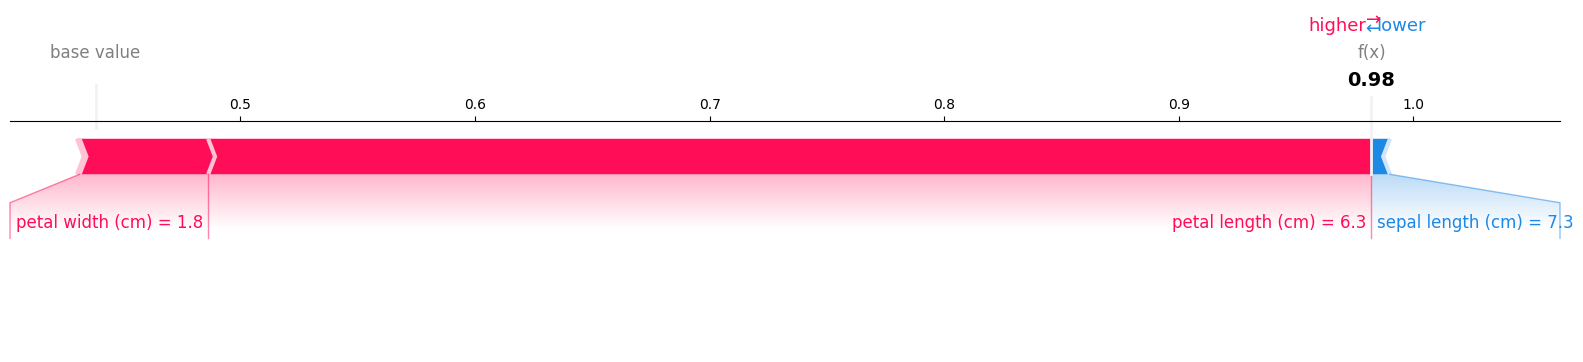


Explanation for sample test index 1 (true label = versicolor):


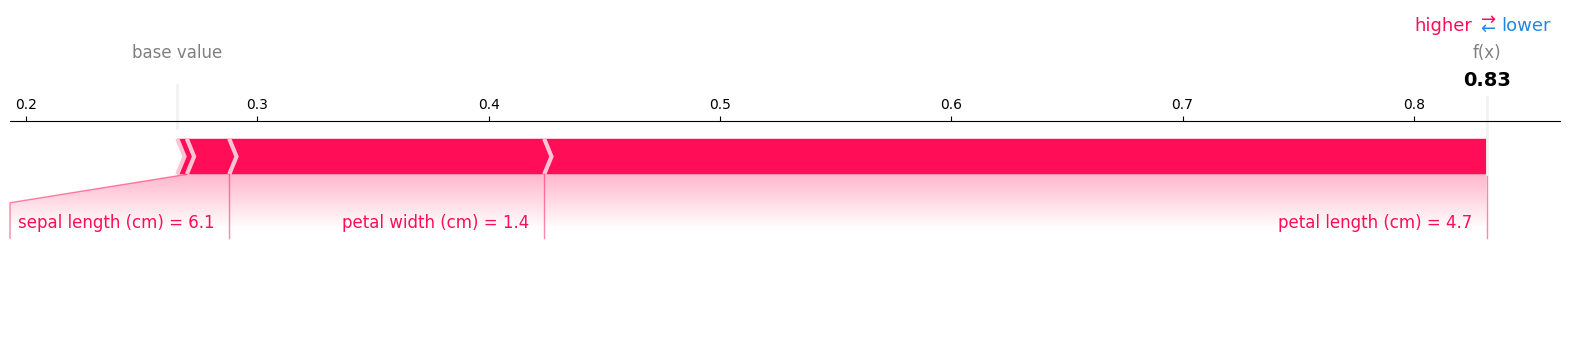


Explanation for sample test index 2 (true label = virginica):


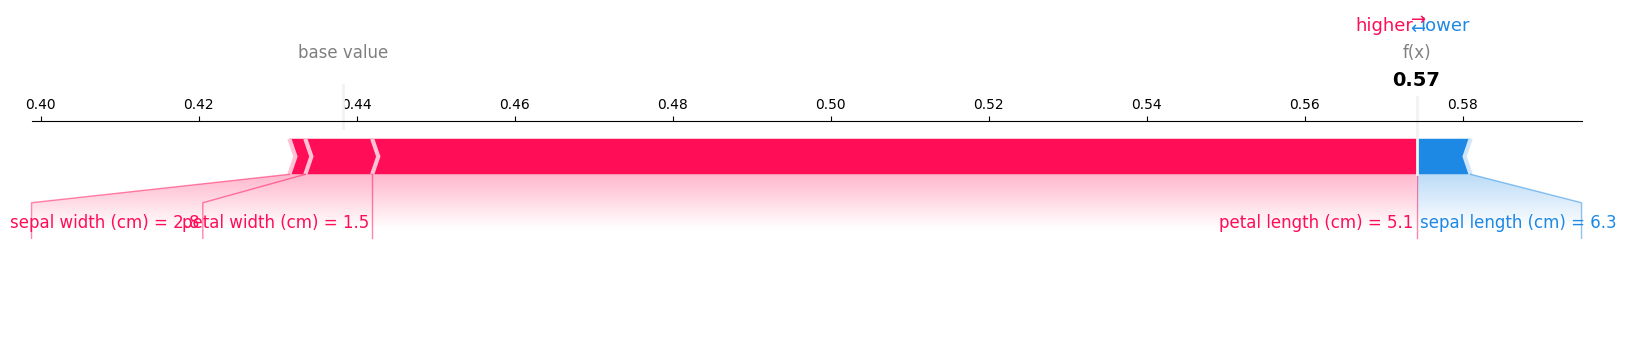

In [30]:
import shap

# use a small background sample for KernelExplainer to be faster
X_background = X_train[np.random.choice(X_train.shape[0], 30, replace=False)]

explainer = shap.KernelExplainer(svc.predict_proba, X_background)

# pick 3 test points to explain
idxs = [0, 1, 2]  # or choose any three indices from X_test
X_explain = X_test[idxs]

shap_values = explainer.shap_values(X_explain)  # (num_samples, num_features, num_outputs) in this case

# visualize for each point
for i, idx in enumerate(idxs):
    pred_class = svc.predict([X_explain[i]])[0]

    print(f"\nExplanation for sample test index {idx} (true label = {target_names[y_test[idx]]}):")

    # Correct indexing for shap_values (num_samples, num_features, num_outputs)
    # Select all features for the current sample (i) and predicted class (pred_class)
    sv = shap_values[i][:, pred_class]

    shap.force_plot(
        explainer.expected_value[pred_class],
        sv,
        X_explain[i],
        feature_names=feature_names,
        matplotlib=True
    )